In [8]:
# train_traffic_model.py
"""
Train an advanced model to predict hourly vehicle counts.
- Uses XGBoost (recommended) if available; otherwise falls back to RandomForest.
- Expects 'traffic.csv' in the same folder (columns: DateTime, Junction, Vehicles, ID).
- Saves model+preprocessor to 'traffic_model.joblib' and test predictions to 'predictions.csv'.
"""

import os
import sys
import joblib
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Try to import xgboost; if missing we'll use RandomForest
USE_XGBOOST = False
try:
    from xgboost import XGBRegressor
    USE_XGBOOST = True
except Exception:
    from sklearn.ensemble import RandomForestRegressor

def load_data(path="traffic.csv"):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}. Put 'traffic.csv' in the same folder as this script.")
    df = pd.read_csv(path)
    return df

def create_time_features(df):
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    # sort per junction/time for lagging
    df = df.sort_values(['Junction','DateTime']).reset_index(drop=True)
    df['hour'] = df['DateTime'].dt.hour
    df['day'] = df['DateTime'].dt.day
    df['month'] = df['DateTime'].dt.month
    df['year'] = df['DateTime'].dt.year
    df['dayofweek'] = df['DateTime'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
    # cyclical hour
    df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
    return df

def create_lag_and_rolling(df):
    # lags per junction
    df['lag1'] = df.groupby('Junction')['Vehicles'].shift(1)
    df['lag24'] = df.groupby('Junction')['Vehicles'].shift(24)
    # rolling means (shift first so current hour not included)
    df['rm_3'] = df.groupby('Junction')['Vehicles'].apply(
        lambda s: s.shift(1).rolling(window=3, min_periods=1).mean()
    ).reset_index(level=0, drop=True)
    df['rm_24'] = df.groupby('Junction')['Vehicles'].apply(
        lambda s: s.shift(1).rolling(window=24, min_periods=1).mean()
    ).reset_index(level=0, drop=True)
    return df

def prepare_features(df):
    # drop columns we won't use
    df = df.copy()
    if 'ID' in df.columns:
        df = df.drop(columns=['ID'])
    # apply time features + lags
    df = create_time_features(df)
    df = create_lag_and_rolling(df)
    # drop rows missing essential lag features (first 24 hours per junction)
    df = df.dropna(subset=['lag1','lag24']).reset_index(drop=True)
    return df

def build_preprocessor(numeric_features):
    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot_junction', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['Junction']),
            ('num', StandardScaler(), numeric_features)
        ],
        remainder='drop'
    )
    return preprocessor


def get_feature_names_from_preprocessor(preprocessor, numeric_features):
    # Construct feature names in same order as preprocessor output
    names = []
    # onehot names
    try:
        ohe = preprocessor.named_transformers_['onehot_junction']
        ohe_names = list(ohe.get_feature_names_out(['Junction']))
        names.extend(ohe_names)
    except Exception:
        # fallback: categories_
        try:
            cats = preprocessor.named_transformers_['onehot_junction'].categories_[0]
            names.extend([f"Junction_{c}" for c in cats])
        except Exception:
            names.append('Junction')
    # numeric names (after scaling)
    names.extend(numeric_features)
    return names

def time_train_test_split(df, test_size=0.2):
    # sort by time globally and do time-based split
    df = df.sort_values('DateTime').reset_index(drop=True)
    split_idx = int(len(df) * (1 - test_size))
    train_df = df.iloc[:split_idx].copy()
    test_df = df.iloc[split_idx:].copy()
    return train_df, test_df

def train_and_evaluate(df, output_model_path='traffic_model.joblib', output_preds_path='predictions.csv'):
    # prepare features
    df = prepare_features(df)
    # feature lists
    numeric_features = ['lag1','lag24','rm_3','rm_24','sin_hour','cos_hour','dayofweek','is_weekend','month']
    categorical_features = ['Junction']  # used in preprocessor

    # Split time-wise
    train_df, test_df = time_train_test_split(df, test_size=0.2)
    print(f"Total rows: {len(df)} | Train: {len(train_df)} | Test: {len(test_df)}")

    # further split train into train/val to use for early stopping (if xgboost)
    train_val_split = int(len(train_df) * 0.9)
    train_sub = train_df.iloc[:train_val_split].copy()
    val_sub = train_df.iloc[train_val_split:].copy()

    X_train = train_sub[numeric_features + categorical_features]
    y_train = train_sub['Vehicles']
    X_val = val_sub[numeric_features + categorical_features]
    y_val = val_sub['Vehicles']
    X_test = test_df[numeric_features + categorical_features]
    y_test = test_df['Vehicles']

    # build & fit preprocessor
    preprocessor = build_preprocessor(numeric_features)
    preprocessor.fit(X_train)
    X_train_t = preprocessor.transform(X_train)
    X_val_t = preprocessor.transform(X_val)
    X_test_t = preprocessor.transform(X_test)

    # train model
    if USE_XGBOOST:
        print("Using XGBoost (recommended).")
        model = XGBRegressor(
            n_estimators=1000,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            objective='reg:squarederror'
        )
        # early stopping with validation set
        model.fit(
            X_train_t, y_train,
            eval_set=[(X_val_t, y_val)],
            early_stopping_rounds=50,
            verbose=20
        )
    else:
        print("XGBoost not found — falling back to RandomForest.")
        model = RandomForestRegressor = __import__('sklearn.ensemble', fromlist=['RandomForestRegressor']).RandomForestRegressor
        model = model(n_estimators=300, n_jobs=-1, random_state=42)
        model.fit(X_train_t, y_train)

    # predictions & evaluation
    y_pred = model.predict(X_test_t)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    print("\nEvaluation on TEST set:")
    print(f"MAE  : {mae:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"R2   : {r2:.4f}")

    # Save model + preprocessor + metadata
    feat_names = get_feature_names_from_preprocessor(preprocessor, numeric_features)
    payload = {
        'model': model,
        'preprocessor': preprocessor,
        'feature_names': feat_names,
        'numeric_features': numeric_features
    }
    joblib.dump(payload, output_model_path)
    print(f"Saved model + preprocessor to: {output_model_path}")

    # Save predictions (aligned with test_df)
    preds_df = test_df[['DateTime','Junction','Vehicles']].copy().reset_index(drop=True)
    preds_df['Predicted'] = y_pred
    preds_df.to_csv(output_preds_path, index=False)
    print(f"Saved test predictions to: {output_preds_path}")

    # (Optional) show top feature importances if available
    try:
        importances = model.feature_importances_
        fi_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)
        print("\nTop features by importance:")
        print(fi_df.head(15).to_string(index=False))
    except Exception:
        pass

    return payload, preds_df

def main():
    print("Loading data...")
    df = load_data("traffic.csv")
    print("Training model (this may take a few minutes)...")
    payload, preds_df = train_and_evaluate(df)
    print("\nDone. Outputs:")
    print(" - model file: traffic_model.joblib (contains model + preprocessor)")
    print(" - predictions file: predictions.csv (test set predictions)")
    print("\nTo load the model later in another script:")
    print(">>> import joblib")
    print(">>> d = joblib.load('traffic_model.joblib')")
    print(">>> model = d['model']; preprocessor = d['preprocessor']")
    print(">>> X_new_processed = preprocessor.transform(X_new_raw); y_pred = model.predict(X_new_processed)")

if __name__ == "__main__":
    main()


Loading data...
Training model (this may take a few minutes)...
Total rows: 48024 | Train: 38419 | Test: 9605
XGBoost not found — falling back to RandomForest.

Evaluation on TEST set:
MAE  : 3.3413
RMSE : 5.6889
R2   : 0.9563
Saved model + preprocessor to: traffic_model.joblib
Saved test predictions to: predictions.csv

Top features by importance:
   feature  importance
      lag1    0.927596
     lag24    0.016295
     rm_24    0.014063
      rm_3    0.012380
  cos_hour    0.010370
  sin_hour    0.007579
     month    0.004622
 dayofweek    0.004124
Junction_3    0.001075
is_weekend    0.000885
Junction_1    0.000521
Junction_2    0.000414
Junction_4    0.000076

Done. Outputs:
 - model file: traffic_model.joblib (contains model + preprocessor)
 - predictions file: predictions.csv (test set predictions)

To load the model later in another script:
>>> import joblib
>>> d = joblib.load('traffic_model.joblib')
>>> model = d['model']; preprocessor = d['preprocessor']
>>> X_new_processed 

In [12]:
import numpy as np
import pandas as pd

def create_features(df):
    df = df.copy()
    df["DateTime"] = pd.to_datetime(df["DateTime"])
    
    # Time-based features
    df["hour"] = df["DateTime"].dt.hour
    df["dayofweek"] = df["DateTime"].dt.dayofweek
    df["month"] = df["DateTime"].dt.month
    df["is_weekend"] = df["dayofweek"].isin([5,6]).astype(int)
    df["sin_hour"] = np.sin(2*np.pi*df["hour"]/24)
    df["cos_hour"] = np.cos(2*np.pi*df["hour"]/24)

    # Lags / rolling means (set to 0 if unknown for new data)
    df["lag1"] = 0
    df["lag24"] = 0
    df["rm_3"] = 0
    df["rm_24"] = 0
    
    return df


In [13]:
import joblib
import pandas as pd

# Load model + preprocessor
d = joblib.load("traffic_model.joblib")
model = d["model"]
preprocessor = d["preprocessor"]

# Example: raw new data
X_new_raw = pd.DataFrame({
    "DateTime": ["2025-09-20 08:00:00"],
    "Junction": [2],
    "ID": [50000]   # dummy, not used
})

# Apply feature engineering
X_new_features = create_features(X_new_raw)

# Preprocess + predict
X_new_processed = preprocessor.transform(X_new_features)
y_pred = model.predict(X_new_processed)

print("Predicted vehicles:", y_pred[0])


Predicted vehicles: 3.8566666666666665


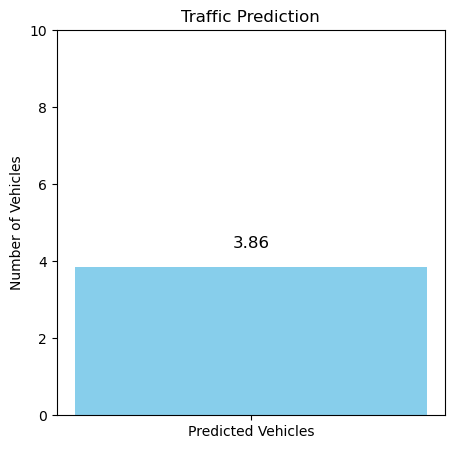

In [14]:
import matplotlib.pyplot as plt

# your prediction
y_pred_value = 3.8566666666666665

# Bar chart
plt.figure(figsize=(5,5))
plt.bar(["Predicted Vehicles"], [y_pred_value], color="skyblue")
plt.title("Traffic Prediction")
plt.ylabel("Number of Vehicles")
plt.ylim(0, max(10, y_pred_value + 5))  # set y-axis a bit higher than prediction
plt.text(0, y_pred_value + 0.5, f"{y_pred_value:.2f}", ha="center", fontsize=12)
plt.show()


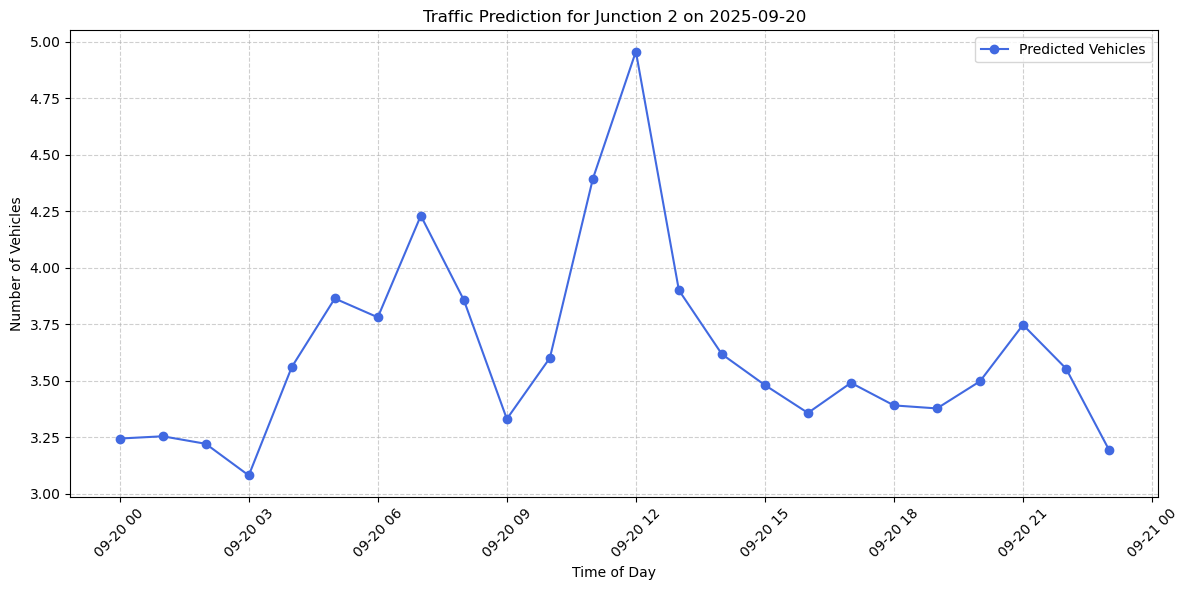

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

# --- Load trained model ---
d = joblib.load("traffic_model.joblib")
model = d["model"]
preprocessor = d["preprocessor"]

# --- Feature engineering function (same as before) ---
def create_features(df):
    df = df.copy()
    df["DateTime"] = pd.to_datetime(df["DateTime"])
    df["hour"] = df["DateTime"].dt.hour
    df["dayofweek"] = df["DateTime"].dt.dayofweek
    df["month"] = df["DateTime"].dt.month
    df["is_weekend"] = df["dayofweek"].isin([5,6]).astype(int)
    df["sin_hour"] = np.sin(2*np.pi*df["hour"]/24)
    df["cos_hour"] = np.cos(2*np.pi*df["hour"]/24)
    df["lag1"] = 0
    df["lag24"] = 0
    df["rm_3"] = 0
    df["rm_24"] = 0
    return df

# --- Generate data for one full day (24 hours) ---
date = "2025-09-20"
junction = 2  # choose junction number
X_new_raw = pd.DataFrame({
    "DateTime": pd.date_range(f"{date} 00:00:00", f"{date} 23:00:00", freq="H"),
    "Junction": [junction]*24,
    "ID": range(50000, 50024)  # dummy IDs
})

# --- Create features ---
X_new_features = create_features(X_new_raw)

# --- Predict ---
X_new_processed = preprocessor.transform(X_new_features)
y_pred = model.predict(X_new_processed)

# --- Visualization ---
plt.figure(figsize=(12,6))
plt.plot(X_new_raw["DateTime"], y_pred, marker="o", color="royalblue", label="Predicted Vehicles")
plt.title(f"Traffic Prediction for Junction {junction} on {date}")
plt.xlabel("Time of Day")
plt.ylabel("Number of Vehicles")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
